In [1]:
import os, glob
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import RFormula

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.5, rc={'text.usetex' : True})

sc = SparkContext('local')
spark = SparkSession(sc)

path = "./input/clean/training_data/"

In [2]:
NC_data = spark.read.csv(path + "NOAA_NC_DAvg_training_data.csv", header=True, inferSchema=True)
NC_data = NC_data.drop(*[t for t in NC_data.columns if t[-1] == 'T']+['date','CLASS'])
NC_data = NC_data.drop(*["MaxTemp", "MinTemp", "MaxRH", "MinRH", "MaxBP", "MinBP","MaxWSpd","MinWSpd"])
NC_data.show(5)

+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+
|             ATemp|               RH|                BP|              WSpd|              Wdir|            SDWDir|             TotPrcp|            TotPAR|           AvgVolt|              Temp|
+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+
| 8.296874999999998|71.97916666666667|           1027.75|1.3093750000000004|249.76041666666666|             17.25|                 0.0|204.30624999999995|13.016666666666666|10.641145833333328|
|11.064583333333331|71.29166666666667|1024.4583333333333|1.7385416666666673|249.57291666666666|16.197916666666668|0.003124999999999...|173.65000000000006|12.969791666666666|11.089062499999999|
|15.534374999999997|          71.18

In [3]:
# vector of features
rf = RFormula(formula="Temp~.")
vector_rf = rf.fit(NC_data).transform(NC_data).select(["features","label"])
vector_rf.show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[8.29687499999999...|10.641145833333328|
|[11.0645833333333...|11.089062499999999|
|[15.5343749999999...|12.167708333333321|
|[19.1302083333333...|13.960937499999993|
|[19.6677083333333...|15.548437499999999|
+--------------------+------------------+
only showing top 5 rows



In [4]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

train, test = vector_rf.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTRegressor(featuresCol="features", maxIter=10, seed = 1230)

# Train model.  This also runs the indexer.
model = gbt.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+-----------------+--------------------+
|        prediction|            label|            features|
+------------------+-----------------+--------------------+
| 5.550873074928804|6.731249999999999|[-3.5770833333333...|
| 9.281037305416303|         4.840625|[-1.9656249999999...|
|5.6626410286829545|6.936458333333337|[-0.6145833333333...|
| 5.906830873484138|7.708333333333331|[0.36562500000000...|
|5.8469762762096495|7.271354166666668|[1.32083333333333...|
+------------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.9971


Text(0.5, 0, 'Index')

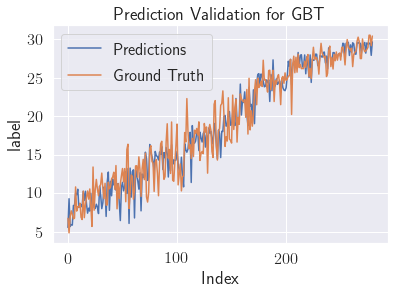

In [5]:
pred = predictions.toPandas()
test_pd = test.toPandas()
sns.lineplot(pred.index,pred.prediction, label="Predictions")
sns.lineplot(pred.index, test_pd.label, label="Ground Truth")
plt.title("Prediction Validation for GBT")
plt.xlabel("Index")